In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import random

2024-11-04 23:59:28.680415: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-04 23:59:28.687291: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-04 23:59:28.735804: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-04 23:59:28.768925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730744968.801545   30787 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730744968.81

In [2]:
# Load and split the Flowers dataset
(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[70%:]"],
    batch_size=-1,#dataset load into memory at once not batches
    as_supervised=True #tuple of image,label
)

2024-11-04 23:59:31.323547: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2024-11-04 23:59:31.421660: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


In [3]:
# Resize images and preprocess inputs
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

In [4]:
# Convert labels to categorical format
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

In [5]:
# Load VGG16 model without the top layer and freeze its weights
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))#pretrained on imagenet ds fullyc layer not included will add our own
base_model.trainable = False #freeze weights of base model

In [6]:
# Build the complete model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(50, activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dense(5, activation='softmax')
])

In [7]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Train the model
history = model.fit(
    train_ds, train_labels,
    epochs=5,
    validation_split=0.2,
    batch_size=32
)

Epoch 1/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.3243 - loss: 3.6510 - val_accuracy: 0.5506 - val_loss: 1.2232
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.6213 - loss: 0.9865 - val_accuracy: 0.6012 - val_loss: 1.0364
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7231 - loss: 0.6981 - val_accuracy: 0.6556 - val_loss: 1.1914
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8042 - loss: 0.5283 - val_accuracy: 0.7121 - val_loss: 1.1511
Epoch 5/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8665 - loss: 0.3716 - val_accuracy: 0.6809 - val_loss: 1.1311


In [9]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_ds, test_labels)
print(f"Loss: {loss}, Accuracy: {accuracy}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6493 - loss: 1.4021
Loss: 1.4087611436843872, Accuracy: 0.6594005227088928


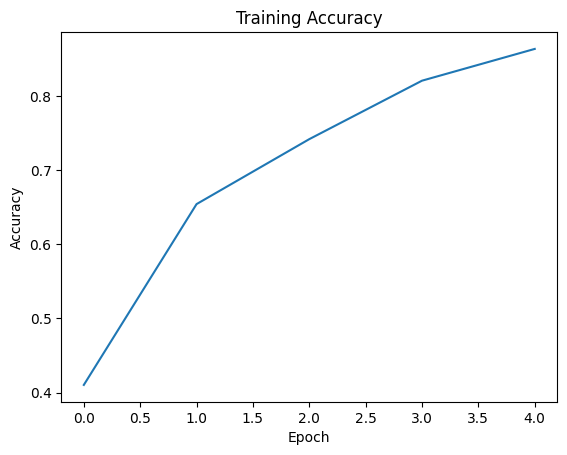

In [10]:
# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


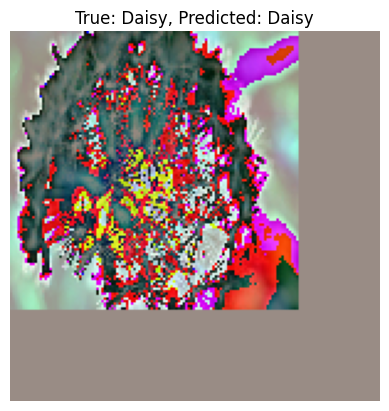

In [13]:
# Function to display a random prediction
def display_random_prediction(test_images, test_labels, model, class_names):
    idx = random.randint(0, len(test_images) - 1)
    image = test_images[idx]
    true_label = np.argmax(test_labels[idx])
    
    # Predict and display
    prediction = model.predict(tf.expand_dims(image, axis=0))
    predicted_label = np.argmax(prediction)
    
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(f"True: {class_names[true_label]}, Predicted: {class_names[predicted_label]}")
    plt.axis('off')
    plt.show()

# Class names for display
class_names = ["Daisy", "Dandelion", "Rose", "Sunflower", "Tulip"]

# Display a random prediction
display_random_prediction(test_ds, test_labels, model, class_names)